Loading dataset...
Original Shape: (4129083, 28)
Cleaning data...
Engineering features...


/tmp/ipython-input-3532520573.py:47: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['start_time_local'] = pd.to_datetime(df['start_time_local'], errors='coerce')


Removing outliers...
Shape after cleaning: (3891003, 18)
Generating EDA Plots...


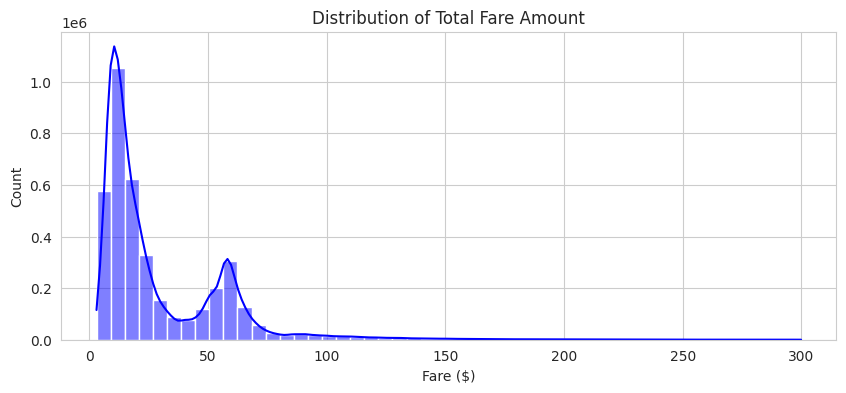

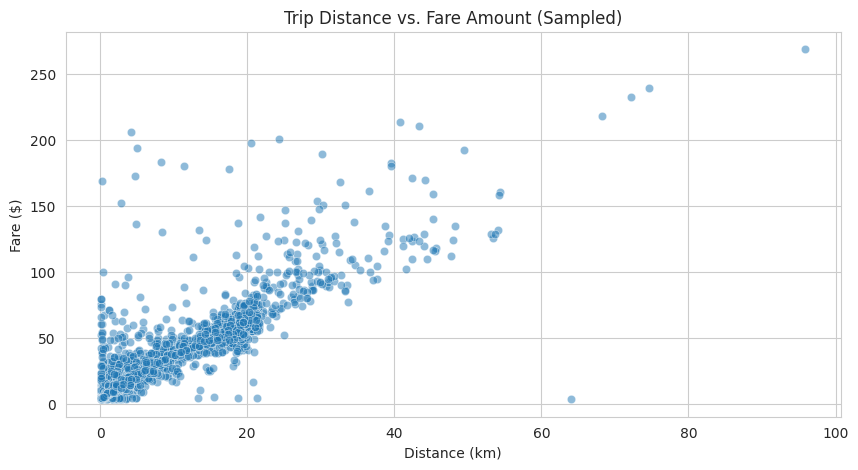

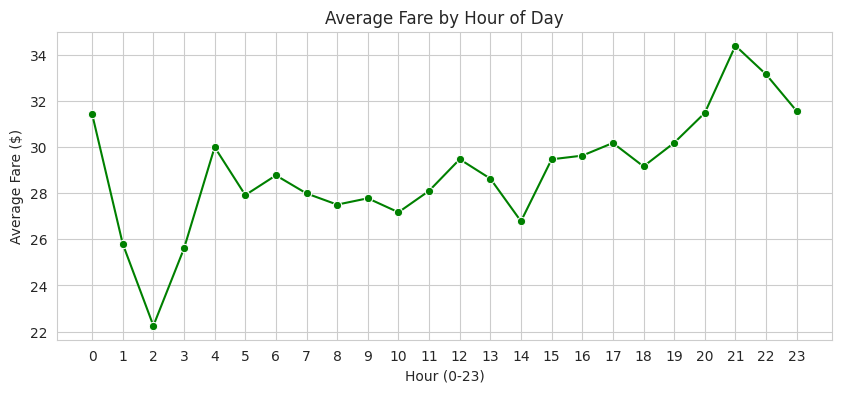

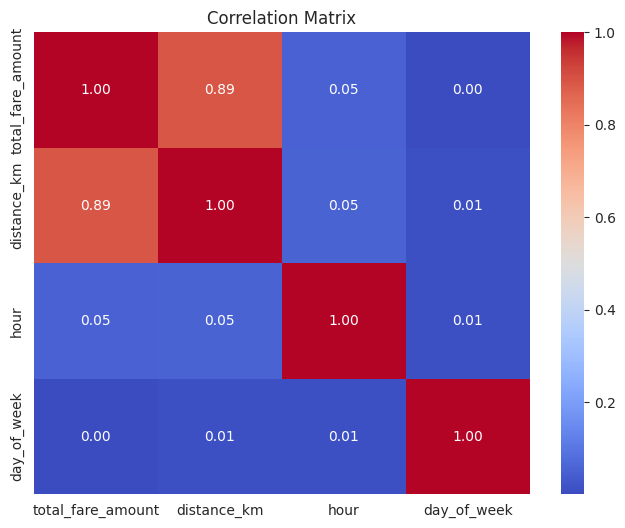

Success! Cleaned data saved as 'cleaned_taxi_data.csv'.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("Loading dataset...")
df = pd.read_csv('/content/drive/MyDrive/Dataset/taxi_trips.csv', low_memory=False)
print(f"Original Shape: {df.shape}")

print("Cleaning data...")

leakage_cols = [
    'meter_fare_amount', 'tip', 'tolls', 'extra_amount',
    'upfront_pricing', 'other_fees', 'sf_exit_fee'
]

noise_cols = [
    'vehicle_placard_number', 'driver_id', 'data_as_of',
    'data_loaded_at', 'fare_type', 'qa_flags'
]

cols_to_drop = leakage_cols + noise_cols
df = df.drop(columns=[c for c in cols_to_drop if c in df.columns], errors='ignore')

df = df.dropna(subset=['pickup_location_latitude', 'pickup_location_longitude',
                       'dropoff_location_latitude', 'dropoff_location_longitude',
                       'total_fare_amount'])
print("Engineering features...")

df['start_time_local'] = pd.to_datetime(df['start_time_local'], errors='coerce')

df['hour'] = df['start_time_local'].dt.hour
df['day_of_week'] = df['start_time_local'].dt.dayofweek # 0=Mon, 6=Sun

def haversine_np(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in km
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    a = np.sin(dphi/2)**2 + np.cos(phi1)*np.cos(phi2)*np.sin(dlambda/2)**2
    return 2 * R * np.arctan2(np.sqrt(a), np.sqrt(1-a))

df['distance_km'] = haversine_np(
    df['pickup_location_latitude'], df['pickup_location_longitude'],
    df['dropoff_location_latitude'], df['dropoff_location_longitude']
)

print("Removing outliers...")

valid_lat = (df['pickup_location_latitude'].between(37, 38)) & \
            (df['dropoff_location_latitude'].between(37, 38))
df = df[valid_lat]

df = df[(df['total_fare_amount'] > 2.50) & (df['total_fare_amount'] < 300)]

df = df[(df['distance_km'] > 0.1) & (df['distance_km'] < 100)]

print(f"Shape after cleaning: {df.shape}")

print("Generating EDA Plots...")

sns.set_style("whitegrid")

plt.figure(figsize=(10, 4))
sns.histplot(df['total_fare_amount'], bins=50, kde=True, color='blue')
plt.title('Distribution of Total Fare Amount')
plt.xlabel('Fare ($)')
plt.show()

plt.figure(figsize=(10, 5))
sample_df = df.sample(5000, random_state=42)
sns.scatterplot(x='distance_km', y='total_fare_amount', data=sample_df, alpha=0.5)
plt.title('Trip Distance vs. Fare Amount (Sampled)')
plt.xlabel('Distance (km)')
plt.ylabel('Fare ($)')
plt.show()

plt.figure(figsize=(10, 4))
hourly_fare = df.groupby('hour')['total_fare_amount'].mean()
sns.lineplot(x=hourly_fare.index, y=hourly_fare.values, marker='o', color='green')
plt.title('Average Fare by Hour of Day')
plt.xlabel('Hour (0-23)')
plt.ylabel('Average Fare ($)')
plt.xticks(range(0, 24))
plt.show()

plt.figure(figsize=(8, 6))
corr_cols = ['total_fare_amount', 'distance_km', 'hour', 'day_of_week']
sns.heatmap(df[corr_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

df.to_csv('cleaned_taxi_data.csv', index=False)
print("Success! Cleaned data saved as 'cleaned_taxi_data.csv'.")

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib
from google.colab import files

print("Loading cleaned dataset...")
df = pd.read_csv('cleaned_taxi_data.csv')
print(f"Data Loaded. Shape: {df.shape}")


features = ['pickup_location_latitude', 'pickup_location_longitude',
            'dropoff_location_latitude', 'dropoff_location_longitude',
            'distance_km', 'hour', 'day_of_week']

X = df[features]
y = df['total_fare_amount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Initializing Random Forest...")
model = RandomForestRegressor(
    n_estimators=60,
    max_depth=20,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

print("Starting Training (this may take 5-10 minutes)...")
model.fit(X_train, y_train)

print("Evaluating Model...")
y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("------------------------------------------------")
print(f"Model Performance:")
print(f"RMSE: ${rmse:.2f} (Average error in dollars)")
print(f"R2 Score: {r2:.4f} (Accuracy percentage approx {r2*100:.1f}%)")
print("------------------------------------------------")

print("Saving model to .pkl file...")
joblib.dump(model, 'ride_fare_model.pkl', compress=3)

print("Downloading file...")
files.download('ride_fare_model.pkl')

Loading cleaned dataset...
Data Loaded. Shape: (3891003, 18)
Initializing Random Forest...
Starting Training (this may take 5-10 minutes)...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  3.5min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


Evaluating Model...


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:    2.6s finished


------------------------------------------------
Model Performance:
RMSE: $9.51 (Average error in dollars)
R2 Score: 0.8810 (Accuracy percentage approx 88.1%)
------------------------------------------------
Saving model to .pkl file...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>